In [1]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
import os

In [3]:
def rescale_frame(frame, percent=50):
    """
    Rescale a frame to a certain percentage compare to its original frame
    """
    width = int(frame.shape[1] * percent / 100)
    height = int(frame.shape[0] * percent / 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

In [2]:
def resize_image(image, target_size):
    """
    target_size: (width, height)
    """
    return cv2.resize(image, target_size)

In [3]:
def recalculate_landmarks(landmarks, image_shape):
    # Tính trung điểm của đoạn nối hông trái và hông phải
    hip_center_x = int((landmarks[23].x + landmarks[24].x) * image_shape[1] / 2)
    hip_center_y = int((landmarks[23].y + landmarks[24].y) * image_shape[0] / 2)

    # Dịch chuyển ảnh để đưa trung tâm của phần hông vào giữa
    translation_x = image_shape[1] // 2 - hip_center_x
    translation_y = image_shape[0] // 2 - hip_center_y

    # Tính toán lại tọa độ của key points sau khi đã dịch chuyển
    for landmark in landmarks:
        landmark.x = (landmark.x * image_shape[1] + translation_x) / image_shape[1]
        landmark.y = (landmark.y * image_shape[0] + translation_y) / image_shape[0]

### 1. Determine important landmarks for plank

In [4]:
IMPORTANT_LMS = [
    "nose",
    "left_shoulder",
    "right_shoulder",
    "left_elbow",
    "right_elbow",
    "left_wrist",
    "right_wrist",
    "left_hip",
    "right_hip",
    "left_knee",
    "right_knee",
    "left_ankle",
    "right_ankle",
    "left_heel",
    "right_heel",
    "left_foot_index",
    "right_foot_index",
]

In [5]:
def extract_key_points_from_image(image_path, label, output_file, is_flip = False):
    # Khởi tạo MediaPipe Pose
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(
        static_image_mode=True, model_complexity=1, smooth_landmarks=True
    )

    image = cv2.imread(image_path)
    if (is_flip):
        image = cv2.flip(image, 1)

    # Ảnh ngang
    if image.shape[1] > image.shape[0]:
        image = resize_image(image, (1200, 675)) # 16:9
    else:
        image = resize_image(image, (675, 1200)) # 9 : 16

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Phát hiện pose
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark

        # Tính toán lại key points sau khi dịch chuyển phần hông vào giữa
        recalculate_landmarks(results.pose_landmarks.landmark, image.shape)
        columns_name = ["label", "horizontal"]
        columns_value = [label, image.shape[1] >= image.shape[0]]
        for id, landmark in enumerate(landmarks):
            land_mark_name = mp_pose.PoseLandmark(id).name.lower()
            if land_mark_name not in IMPORTANT_LMS:
                continue
            columns_name += [
                f"{ land_mark_name }_x",
                f"{ land_mark_name }_y",
                f"{ land_mark_name }_z",
            ]

            columns_value += [
                landmark.x,
                landmark.y,
                landmark.z,
            ]

        df_key_points = pd.DataFrame([columns_value], columns=columns_name)

        with open(output_file, "a") as f:
            # header=f.tell()==0 sẽ ghi tiêu đề nếu file trống
            df_key_points.to_csv(f, header=f.tell() == 0, index=False)

    else:
        print(image_path)

    pose.close()

In [6]:
def extract_key_points_from_to_csv(input_folder, folder_type, output_file):
    """
    Extract key points from images are in the input folder to the CSV file
    """
    is_flip = False
    for _ in range(1, 3):
        for image_name in os.listdir(input_folder):
            image_path = os.path.join(input_folder, image_name)
            extract_key_points_from_image(image_path, folder_type, output_file, is_flip)
        is_flip = not is_flip

### 2. Collect data from category folder of plank

In [14]:
folder_qty = 5

In [15]:
# Collect data from correct folders
for idx in range(1, folder_qty + 1):
    extract_key_points_from_to_csv(
        f"../../keypoints/data/images/plank_pose_0{idx}_selected/Correct", "C", "train.csv"
    )
    print(f"Done folder: {idx}")

Done folder: 1


In [9]:
# Collect data from wrong folders
for idx in range(1, folder_qty + 1):
    extract_key_points_from_to_csv(
        f"../../keypoints/data/images/plank_pose_0{idx}_selected/Wrong",
        "W",
        "train.csv",
    )
    print(f"Done folder: {idx}")

Done folder: 1
Done folder: 2
Done folder: 3
Done folder: 4
../../keypoints/data/images/plank_pose_05_selected/Wrong\frame_36.jpg
Done folder: 5


### 3. Clean the extracted data

In [10]:
def remove_duplicate_row(input_file, output_file):
    # Đọc dữ liệu từ file CSV
    df = pd.read_csv(input_file)

    # Xoá các hàng trùng lặp
    df_new = df.drop_duplicates()

    # Ghi dữ liệu đã được xử lý vào file CSV mới
    df_new.to_csv(output_file, index=False)

In [18]:
remove_duplicate_row("train.csv", "train_clean.csv")

In [19]:
plank_df = pd.read_csv("train_clean.csv")

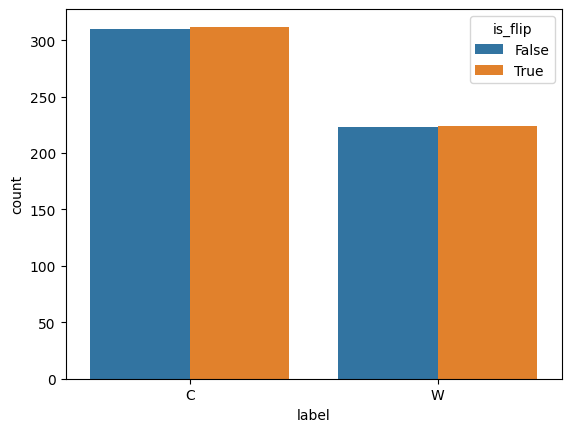

In [20]:
sns.countplot(plank_df, x="label", hue="is_flip");

In [8]:
import pandas as pd
plank_df = pd.read_csv("train_clean.csv")
# plank_df2 = pd.read_csv("train_clean2.csv")

In [6]:
plank_df.shape

(1069, 53)

In [ ]:
# plank_df2.shape